In [1]:
#POOT Library
from ROOT import TMVA, TFile, TTree, TCut, TString
#DNN Library Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Optimizer SWATS 
import swats
#numpy, pandas, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from importlib import reload
import pandas as pd
import random
from array import array
#ML library
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
#XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
#Cuda Library
from numba import cuda
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import gc 
from scipy.stats import poisson
import multiprocessing

Welcome to JupyROOT 6.19/01


Cuda Functions for data normalization
1. Calculate sum of a vector

2. Calculate mean value

3. Calculate variance

Function use to do Guassian Normalization:
Mean:
$$\mu_{i}=\frac{\sum x_{i}\times w_{i}}{\sum w_{i}}$$
Variance:
$$\sigma_{i}=\frac{\sum (x_{i}-\mu_{i})^{2}\times w_{i}}{\frac{N-1}{N}\times\sum w_{i}}$$
Normalized input feature:
$$\bar{x_{i}}=\frac{x_{i}-\mu_{i}}{\sigma_{i}}$$

cuda function is in cuda_guass_normal/__iniit__.py
use pip install . or pip install cuda_guass_normal first
package information: https://pypi.org/project/cuda-guass-normal/

In [2]:
import cuda_guass_normal

Load signal and background files:

In [3]:
signalFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_sig.root")
backgroundFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_bkg.root")

signalTree = signalFile.Get("ntup")
backgroundTree = backgroundFile.Get("ntup")

signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  847545
background events number before cut is:  22274444


Convert minitree into numpy and dataframe:

In [4]:
variable_names=["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [5]:
dim = len(variable_names)-3

In [6]:
print(dim)

22


In [7]:
sig_variable_names=["weight","m_hh_truth","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [8]:
print(sig_variable_names.index("m_hh_truth"))

1


In [9]:
signalArray=signalTree.AsMatrix(sig_variable_names)

backgroundArray=backgroundTree.AsMatrix(sig_variable_names)
    
print(signalArray.shape)
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal_df=pd.DataFrame(data=signalArray,columns=sig_variable_names)
background_df=pd.DataFrame(data=backgroundArray,columns=sig_variable_names)

(847545, 26)
signal yield before cut is:  188883.40753109788
background yield before cut is: 1859332.62849125


In [10]:
signal_df = signal_df[(signal_df["m_hh_truth"]>0)]

In [ ]:
signal_df = signal_df[((signal_df["m_hh_truth"]>1100)|(signal_df["m_hh_truth"]<900))]

In [11]:
signal_df = signal_df[((signal_df["m_hh_truth"]<405)&(signal_df["m_hh_truth"]>395))]

In [12]:
signal_df.describe()

weight  m_hh_truth         is_em         is_me      bjet_0_pt  \
count  5.937200e+04     59372.0  59372.000000  59372.000000   59372.000000   
mean   1.034278e+00       400.0      0.191066      0.155191  102222.811074   
std    7.681958e-01         0.0      0.393145      0.362090   35244.138697   
min    2.016711e-08       400.0      0.000000      0.000000   20917.679688   
25%    4.390303e-02       400.0      0.000000      0.000000   76921.421875   
50%    1.382305e+00       400.0      0.000000      0.000000   99054.242188   
75%    1.689003e+00       400.0      0.000000      0.000000  124061.126953   
max    4.462970e+00       400.0      1.000000      1.000000  359750.187500   

         bjet_0_eta      bjet_1_pt    bjet_1_eta           ll_m  \
count  59372.000000   59372.000000  59372.000000   59372.000000   
mean      -0.001816   47201.476356      0.001410   38871.230771   
std        1.082307   20101.585664      1.156006   15709.421383   
min       -2.499325   20000.705078     -2.499595   15000.830078   
25%       -0.787690   31109.665527     -0.859555   26089.156250   
50%        0.003575   43387.322266     -0.004938   36074.789062   
75%        0.780053   59365.701172      0.869760   50045.788086   
max        2.499600  212234.390625      2.499914  109979.226562   

               ll_pt  ...   bb_deltaeta     bb_deltapt        met_met  \
count   59372.000000  ...  59372.000000   59372.000000   59372.000000   
mean    82069.874271  ...     -0.003226   55021.334726   69188.044665   
std     37694.401367  ...      1.055395   39354.885452   37045.089224   
min      1274.397827  ...     -4.917831       0.812500     187.169876   
25%     52831.908203  ...     -0.784216   22761.320312   40701.198242   
50%     76070.363281  ...      0.000482   48326.695312   64928.800781   
75%    106996.083984  ...      0.766033   80753.687500   93162.779297   
max    303589.812500  ...      4.894028  304058.093750  276037.062500   

            met_sig       met_phi    mt_lep0_met    mt_lep1_met        m_bbll  \
count  59372.000000  59372.000000   59372.000000   59372.000000  5.937200e+04   
mean       4.334704      0.006524   53935.960335   41347.820962  2.709580e+05   
std        2.168184      1.818026   36795.380905   26900.615145  6.741174e+04   
min        0.011474     -3.141556       2.344540       0.513783  6.484484e+04   
25%        2.654896     -1.575825   23820.534180   19765.908203  2.280640e+05   
50%        4.174390      0.006402   49354.886719   38517.349609  2.659213e+05   
75%        5.837011      1.585037   78438.998047   59017.663086  3.072340e+05   
max       13.853429      3.141161  368953.281250  234125.109375  1.462588e+06   

          m_bbllmet          m_hh  
count  5.937200e+04  5.937200e+04  
mean   3.681309e+05  4.087735e+05  
std    7.664264e+04  2.510201e+05  
min    1.283683e+05  0.000000e+00  
25%    3.227992e+05  3.442134e+05  
50%    3.633649e+05  4.675624e+05  
75%    4.046128e+05  5.693863e+05  
max    1.581035e+06  1.851554e+06  

[8 rows x 26 columns]

In [13]:
background_df.describe()

weight  m_hh_truth         is_em         is_me     bjet_0_pt  \
count  2.227444e+07  22274444.0  2.227444e+07  2.227444e+07  2.227444e+07   
mean   8.347381e-02         0.0  3.270067e-01  2.698629e-01  9.480406e+04   
std    1.679565e-01         0.0  4.691197e-01  4.438884e-01  5.116993e+04   
min   -7.696216e+01         0.0  0.000000e+00  0.000000e+00  2.002584e+04   
25%    2.615894e-02         0.0  0.000000e+00  0.000000e+00  6.275604e+04   
50%    4.834323e-02         0.0  0.000000e+00  0.000000e+00  8.426745e+04   
75%    1.064505e-01         0.0  1.000000e+00  1.000000e+00  1.137532e+05   
max    8.287585e+01         0.0  1.000000e+00  1.000000e+00  2.654668e+06   

         bjet_0_eta     bjet_1_pt    bjet_1_eta          ll_m         ll_pt  \
count  2.227444e+07  2.227444e+07  2.227444e+07  2.227444e+07  2.227444e+07   
mean   3.552925e-04  5.388725e+04  1.076692e-03  5.879532e+04  6.621933e+04   
std    1.088993e+00  3.061933e+04  1.170117e+00  2.291598e+04  3.559094e+04   
min   -2.499999e+00  2.000000e+04 -2.500000e+00  1.500001e+04  1.366817e+01   
25%   -7.987415e-01  3.304134e+04 -8.804259e-01  4.154046e+04  4.219752e+04   
50%    8.298482e-04  4.671686e+04  1.591493e-03  5.787637e+04  6.123999e+04   
75%    7.989457e-01  6.573487e+04  8.826860e-01  7.326857e+04  8.430535e+04   
max    2.499999e+00  1.685634e+06  2.499999e+00  1.100000e+05  1.751289e+06   

       ...   bb_deltaeta    bb_deltapt       met_met       met_sig  \
count  ...  2.227444e+07  2.227444e+07  2.227444e+07  2.227444e+07   
mean   ... -7.213995e-04  4.091681e+04  7.719961e+04  4.983021e+00   
std    ...  1.357969e+00  4.172222e+04  4.639653e+04  2.619173e+00   
min    ... -4.989982e+00  0.000000e+00  7.075400e+00  6.494655e-04   
25%    ... -9.350071e-01  1.377334e+04  4.458004e+04  2.978754e+00   
50%    ... -1.381338e-04  3.031670e+04  7.052689e+04  4.720921e+00   
75%    ...  9.339392e-01  5.534830e+04  1.009006e+05  6.693117e+00   
max    ...  4.995625e+00  2.376301e+06  2.357084e+06  4.081993e+01   

            met_phi   mt_lep0_met   mt_lep1_met        m_bbll     m_bbllmet  \
count  2.227444e+07  2.227444e+07  2.227444e+07  2.227444e+07  2.227444e+07   
mean  -1.169146e-02  8.889294e+04  5.805532e+04  2.731672e+05  3.781724e+05   
std    1.813525e+00  5.211447e+04  3.184025e+04  1.098275e+05  1.268704e+05   
min   -3.141592e+00  1.665384e-02  4.018213e-04  4.398616e+04  5.769907e+04   
25%   -1.582248e+00  5.070008e+04  3.365272e+04  2.072397e+05  3.000693e+05   
50%   -2.377049e-02  8.599371e+04  5.795662e+04  2.521556e+05  3.571480e+05   
75%    1.559133e+00  1.200273e+05  8.022635e+04  3.117956e+05  4.289402e+05   
max    3.141593e+00  1.908282e+06  1.206576e+06  7.115014e+06  7.230100e+06   

               m_hh  
count  2.227444e+07  
mean   1.951947e+05  
std    2.154091e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    2.558316e+05  
75%    3.478096e+05  
max    8.043632e+06  

[8 rows x 26 columns]

select events in HM/DF (region4) region $$m_{ll}<75$$ GeV and different flavor lepton pair:

In [14]:
signal_df = signal_df.drop(columns=["m_hh_truth"])
background_df = background_df.drop(columns=["m_hh_truth"])

In [15]:
signal_df_region4=signal_df[(signal_df["ll_m"]<75000.0)&((signal_df["is_em"]==1)|(signal_df["is_me"]==1))]
background_df_region4=background_df[(background_df["ll_m"]<75000.0)&((background_df["is_em"]==1)|(background_df["is_me"]==1))]
SigYield=signal_df_region4["weight"].sum()
BkgYield=background_df_region4["weight"].sum()
SBratio=SigYield/BkgYield
print("signal yield in region 4 is: ",SigYield)
print("background yield in region 4 is: ",BkgYield)
print("S/B ratio is: ",SBratio)

signal yield in region 4 is:  30476.925957174142
background yield in region 4 is:  697642.5163715091
S/B ratio is:  0.04368559146264037


Pre-cut before feed to DNN:
$$80<m_{bb}<150 GeV$$ $$\Delta R(bb)<2.8$$

In [ ]:
plt.hist(signal_df_region4["m_hh_truth"].values,bins=20,weights=signal_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [ ]:
plt.hist(background_df_region4["m_hh_truth"].values,bins=20,weights=background_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [ ]:
plt.figure(figsize=(8,6))
plt.xlim(0,1200)
plt.hist(background_df_region4["m_hh_truth"].values,bins=20,range=[0, 1200],weights=background_df_region4["weight"].values,fill=False, color='red',normed=1,histtype='step',label="background")
plt.hist(signal_df_region4["m_hh_truth"].values,bins=20,range=[0, 1200],weights=signal_df_region4["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.ylabel('Events/60 GeV',fontsize=15)
plt.xlabel('m_hh_truth [GeV]',fontsize=15)
figure_fig = plt.gcf()
figure_fig.savefig('../figures/1122/m_hh_truth_no1100.pdf', format='pdf', dpi=500)

In [ ]:
def sample_value(leng, target_df, weight_df, variable_name, weight_name):
    target_np = target_df[variable_name].values
    weight_np = weight_df[weight_name].values
    sum_weight = sum(weight_np)
    weight_np = weight_np/sum_weight
    result_np = []
    #for num in source_np:
        #source_np[i] = np.random.choice(target_np, p = weight_np, replace=True)
        #i=i+1
        #print(i)
    result_np = np.random.choice(target_np, p = weight_np, replace=True,size=leng)
    return(result_np)
    

In [ ]:
result_np = sample_value(len(background_df_region4["m_hh_truth"].values), signal_df_region4, signal_df_region4,
                         "m_hh_truth","weight")
                         

In [ ]:
print(result_np.reshape(-1,1))

In [ ]:
print(len(result_np.reshape(-1,1)))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(result_np,bins=20,range=[0,1200],weights=background_df_region4["weight"].values,fill=False, color='red',normed=1,histtype='step',label="sampled background")
plt.hist(signal_df_region4["m_hh_truth"].values,bins=20,range=[0,1200],weights=signal_df_region4["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.xlim(0,1200)
plt.ylabel('Events/60 GeV',fontsize=15)
plt.xlabel('m_hh_truth [GeV]',fontsize=15)
figure_fig = plt.gcf()
figure_fig.savefig('../figures/1122/sampled_m_hh_truth_no1000.pdf', format='pdf', dpi=500)

In [ ]:
background_df_region4_np = background_df_region4.values

background_df_region4_np[:,1]=result_np

background_df_region4 = pd.DataFrame(data=background_df_region4_np, columns=sig_variable_names)

plt.hist(background_df_region4["m_hh_truth"].values,bins=20,weights=background_df_region4["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [ ]:
background_df_region4.describe()

In [ ]:
signal_df_region4.describe()

In [16]:
signal_df_cut=signal_df_region4#[(signal_df_region4["bb_m"]>80000.0)&(signal_df_region4["bb_m"]<150000.0)&(signal_df_region4["bb_deltar"]<2.8)]
background_df_cut=background_df_region4#[(background_df_region4["bb_m"]>80000.0)&(background_df_region4["bb_m"]<150000.0)&(background_df_region4["bb_deltar"]<2.8)]
SigYield1=signal_df_cut["weight"].sum()
BkgYield1=background_df_cut["weight"].sum()
SBratio=SigYield1/BkgYield1
print("signal yield in region 4 after precut is: ",SigYield1)
print("background yield in region 4 after precut is: ",BkgYield1)
print("S/B ratio is: ",SBratio)

signal yield in region 4 after precut is:  30476.925957174142
background yield in region 4 after precut is:  697642.5163715091
S/B ratio is:  0.04368559146264037


In Guassian normalization, mean and variance are calculated using total signal+background event in HM/DF region:

In [17]:
dataNormal_pre=signal_df_cut.append(background_df_cut)
dataNormal_weight_df=dataNormal_pre["weight"]
dataNormal_df=dataNormal_pre.drop(columns=["weight","is_em","is_me"])
dataNormal_df.describe()

dataNormal=dataNormal_df.values
dataNormal_weight=dataNormal_weight_df.values

Add label to signal and background:

In [18]:
signal_df_cut["label"]=1
background_df_cut["label"]=0

signal_df_cut.describe()

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


weight         is_em         is_me      bjet_0_pt    bjet_0_eta  \
count  20305.000000  20305.000000  20305.000000   20305.000000  20305.000000   
mean       1.500957      0.552229      0.447771  102159.282915      0.007568   
std        0.435996      0.497277      0.497277   35345.266291      1.088341   
min        0.000002      0.000000      0.000000   21433.679688     -2.499325   
25%        1.360478      0.000000      0.000000   76829.445312     -0.786576   
50%        1.608850      1.000000      0.000000   98965.187500      0.015264   
75%        1.755953      1.000000      1.000000  123960.398438      0.801486   
max        4.462970      1.000000      1.000000  302334.031250      2.499092   

           bjet_1_pt    bjet_1_eta          ll_m          ll_pt     ll_deltar  \
count   20305.000000  20305.000000  20305.000000   20305.000000  20305.000000   
mean    47114.444726     -0.003868  37832.628499   88707.940611      1.062451   
std     20017.299330      1.156717  14224.458205   38867.903479      0.618646   
min     20000.705078     -2.499401  15000.830078    2953.756348      0.194361   
25%     31118.310547     -0.880997  26156.425781   58682.671875      0.610290   
50%     43219.312500     -0.013235  36350.820312   85686.289062      0.901033   
75%     59135.570312      0.868252  47950.769531  114980.445312      1.342741   
max    197983.546875      2.499761  74963.335938  303589.812500      3.881016   

       ...     bb_deltapt        met_met       met_sig       met_phi  \
count  ...   20305.000000   20305.000000  20305.000000  20305.000000   
mean   ...   55044.838207   65931.955703      4.168742      0.014681   
std    ...   39557.742514   36577.901922      2.176064      1.810946   
min    ...       3.375000     187.169876      0.011474     -3.140864   
25%    ...   22542.121094   37718.515625      2.480744     -1.549792   
50%    ...   48193.746094   60592.574219      3.941031      0.025276   
75%    ...   81092.312500   89051.500000      5.652178      1.582833   
max    ...  251410.875000  247864.046875     13.084551      3.141161   

         mt_lep0_met    mt_lep1_met        m_bbll     m_bbllmet          m_hh  \
count   20305.000000   20305.000000  2.030500e+04  2.030500e+04  2.030500e+04   
mean    61022.310307   44431.084530  2.781539e+05  3.709027e+05  3.991705e+05   
std     36494.623256   27305.353246  6.702218e+04  7.495235e+04  2.745870e+05   
min         6.601645       2.088106  7.622591e+04  1.411877e+05  0.000000e+00   
25%     32208.593750   22460.929688  2.363990e+05  3.271495e+05  0.000000e+00   
50%     59641.894531   42637.804688  2.753950e+05  3.665758e+05  4.736996e+05   
75%     85520.015625   63239.867188  3.145663e+05  4.066916e+05  5.899541e+05   
max    288737.687500  234125.109375  1.462588e+06  1.581035e+06  1.851554e+06   

         label  
count  20305.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0  

[8 rows x 26 columns]

Split training and testing sub-sample. Test size=0.2

In [19]:
signal_df_train1,signal_df_test1=train_test_split(signal_df_cut,test_size=0.2)
background_df_train1,background_df_test1=train_test_split(background_df_cut,test_size=0.2)

Drop negative weight events in training and testing. Negative events will cause DNN trainning stop too early and loss oscillation in late epoches.

In [20]:
signal_df_train=signal_df_train1[signal_df_train1["weight"]>0]
signal_df_test=signal_df_test1[signal_df_test1["weight"]>0]
background_df_train=background_df_train1[background_df_train1["weight"]>0]
background_df_test=background_df_test1[background_df_test1["weight"]>0]

signal_df_train.describe()

weight         is_em         is_me      bjet_0_pt    bjet_0_eta  \
count  16244.000000  16244.000000  16244.000000   16244.000000  16244.000000   
mean       1.502897      0.551835      0.448165  102196.064819      0.011865   
std        0.435092      0.497321      0.497321   35338.885689      1.088822   
min        0.000002      0.000000      0.000000   21433.679688     -2.499325   
25%        1.363352      0.000000      0.000000   76891.361328     -0.783755   
50%        1.610047      1.000000      0.000000   99109.648438      0.019711   
75%        1.756993      1.000000      1.000000  123892.611328      0.809541   
max        4.462970      1.000000      1.000000  302334.031250      2.499092   

           bjet_1_pt    bjet_1_eta          ll_m          ll_pt     ll_deltar  \
count   16244.000000  16244.000000  16244.000000   16244.000000  16244.000000   
mean    47135.028241     -0.000550  37904.590921   88787.676756      1.064161   
std     20085.375725      1.159562  14241.226025   38924.760868      0.620920   
min     20000.705078     -2.499401  15000.830078    2953.756348      0.194361   
25%     31113.409180     -0.878926  26204.415039   58644.231445      0.608874   
50%     43239.615234     -0.018032  36457.193359   85899.503906      0.903058   
75%     59131.276367      0.875790  48032.242188  114990.750000      1.345870   
max    197983.546875      2.499761  74963.335938  303589.812500      3.881016   

       ...     bb_deltapt        met_met       met_sig       met_phi  \
count  ...   16244.000000   16244.000000  16244.000000  16244.000000   
mean   ...   55061.036589   65962.717867      4.169387      0.011846   
std    ...   39510.391479   36557.669254      2.173567      1.818299   
min    ...       3.375000     187.169876      0.011474     -3.140864   
25%    ...   22664.649414   37717.091797      2.480883     -1.572127   
50%    ...   48363.605469   60528.548828      3.938642      0.021253   
75%    ...   80863.687500   89050.134766      5.644704      1.589228   
max    ...  251410.875000  247864.046875     13.084551      3.141161   

         mt_lep0_met    mt_lep1_met        m_bbll     m_bbllmet          m_hh  \
count   16244.000000   16244.000000  1.624400e+04  1.624400e+04  1.624400e+04   
mean    61200.783457   44471.375890  2.782380e+05  3.710549e+05  3.983123e+05   
std     36511.429132   27324.773781  6.724004e+04  7.510731e+04  2.744665e+05   
min         6.601645      19.663914  8.329815e+04  1.411877e+05  0.000000e+00   
25%     32368.241211   22535.461914  2.364150e+05  3.271761e+05  0.000000e+00   
50%     59913.521484   42678.365234  2.754077e+05  3.667143e+05  4.730960e+05   
75%     85594.480469   63180.277344  3.147900e+05  4.070037e+05  5.893060e+05   
max    288737.687500  234125.109375  1.462588e+06  1.581035e+06  1.802540e+06   

         label  
count  16244.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0  

[8 rows x 26 columns]

Scale total weight of signal= total weight of background

In [21]:
background_importance = 1.0 # set importance of background
train_ratio=signal_df_train["weight"].sum()/background_df_train["weight"].sum()*background_importance
test_ratio=signal_df_test["weight"].sum()/background_df_test["weight"].sum()*background_importance
signal_df_train["weight"]=signal_df_train["weight"]/train_ratio
signal_df_test["weight"]=signal_df_test["weight"]/test_ratio

Create trainning and testing dataset:

In [22]:
data_df_train=signal_df_train.append(background_df_train)
data_df_test=signal_df_test.append(background_df_test)

data_df_train=shuffle(data_df_train)
data_df_test=shuffle(data_df_test)

data_train_label=data_df_train["label"]
data_train_weight=data_df_train["weight"]
data_train_data=data_df_train.drop(columns=["weight","label","is_me","is_em"])
data_test_label=data_df_test["label"]
data_test_weight=data_df_test["weight"]
data_test_data=data_df_test.drop(columns=["weight","label","is_me","is_em"])

In [23]:
data_train_data.describe()

bjet_0_pt    bjet_0_eta     bjet_1_pt    bjet_1_eta          ll_m  \
count  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06   
mean   9.368401e+04  8.203677e-04  5.386704e+04  1.528825e-03  4.927164e+04   
std    4.798317e+04  1.082870e+00  2.930615e+04  1.166493e+00  1.594073e+04   
min    2.003605e+04 -2.499996e+00  2.000002e+04 -2.499998e+00  1.500002e+04   
25%    6.303411e+04 -7.916873e-01  3.349497e+04 -8.761103e-01  3.704722e+04   
50%    8.393805e+04  8.832302e-04  4.710568e+04  1.853498e-03  5.061352e+04   
75%    1.123755e+05  7.932483e-01  6.579808e+04  8.798443e-01  6.272313e+04   
max    2.133085e+06  2.499997e+00  1.685634e+06  2.499999e+00  7.499999e+04   

              ll_pt     ll_deltar   ll_deltaeta   ll_deltaphi          bb_m  \
count  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06   
mean   6.539318e+04  1.628986e+00 -6.983525e-04 -9.568614e-04  1.473632e+05   
std    3.318612e+04  7.208500e-01  9.486784e-01  1.507723e+00  9.303110e+04   
min    2.002133e+01  4.699874e-02 -3.277065e+00 -3.141593e+00  1.012777e+04   
25%    4.264728e+04  1.069772e+00 -7.000716e-01 -1.147133e+00  8.508743e+04   
50%    6.092889e+04  1.532749e+00 -1.063645e-03 -8.804798e-04  1.275911e+05   
75%    8.308934e+04  2.116960e+00  6.991702e-01  1.145306e+00  1.860557e+05   
max    1.294314e+06  4.236977e+00  3.198176e+00  3.141592e+00  5.904068e+06   

       ...   bb_deltaeta    bb_deltapt       met_met       met_sig  \
count  ...  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06   
mean   ... -7.084569e-04  3.981697e+04  7.866486e+04  5.094265e+00   
std    ...  1.337539e+00  3.931254e+04  4.594707e+04  2.586906e+00   
min    ... -4.979816e+00  0.000000e+00  2.330228e+01  1.632308e-03   
25%    ... -9.227787e-01  1.365376e+04  4.660123e+04  3.127278e+00   
50%    ... -3.757775e-04  2.988725e+04  7.225327e+04  4.850157e+00   
75%    ...  9.210663e-01  5.416707e+04  1.021439e+05  6.795263e+00   
max    ...  4.993550e+00  2.109494e+06  1.480861e+06  2.931964e+01   

            met_phi   mt_lep0_met   mt_lep1_met        m_bbll     m_bbllmet  \
count  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06  6.663411e+06   
mean  -1.121660e-02  8.774614e+04  5.748964e+04  2.614067e+05  3.686110e+05   
std    1.813816e+00  4.971896e+04  3.060397e+04  9.850514e+04  1.173003e+05   
min   -3.141592e+00  3.711235e-02  4.018213e-04  4.398616e+04  7.142002e+04   
25%   -1.582672e+00  5.151086e+04  3.416801e+04  2.000733e+05  2.946898e+05   
50%   -2.271741e-02  8.583286e+04  5.793445e+04  2.429904e+05  3.497258e+05   
75%    1.560048e+00  1.181418e+05  7.929640e+04  2.990403e+05  4.179874e+05   
max    3.141592e+00  1.226694e+06  6.107881e+05  6.111214e+06  6.233046e+06   

               m_hh  
count  6.663411e+06  
mean   1.890697e+05  
std    2.173445e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    3.542777e+05  
max    6.020829e+06  

[8 rows x 22 columns]

Convert dataframe into numpy array:

In [24]:
dataTrainSample=data_train_data.values
dataTestSample=data_test_data.values
dataTrainWeight=data_train_weight.values
dataTestWeight=data_test_weight.values
dataTrainLabel=data_train_label.values
dataTestLabel=data_test_label.values

Prepare signal and background array for performance checking:

In [25]:
signal_df_weight=signal_df_cut["weight"]
signal_df_data=signal_df_cut.drop(columns=["weight","label","is_me","is_em"])
background_df_weight=background_df_cut["weight"]
background_df_data=background_df_cut.drop(columns=["weight","label","is_me","is_em"])
signalSample=signal_df_data.values
backgroundSample=background_df_data.values
signalWeight=signal_df_weight.values
backgroundWeight=background_df_weight.values

Normalize input featrues:

In [26]:
reload(cuda_guass_normal)

dataTrainSample1=cuda_guass_normal.guass_normal(dataTrainSample,dataNormal,dataNormal_weight)
dataTestSample1=cuda_guass_normal.guass_normal(dataTestSample,dataNormal,dataNormal_weight)

signalSample1=cuda_guass_normal.guass_normal(signalSample,dataNormal,dataNormal_weight)
backgroundSample1=cuda_guass_normal.guass_normal(backgroundSample,dataNormal,dataNormal_weight)

(array([6.551517e+06, 1.047410e+05, 5.843000e+03, 9.940000e+02,
        2.300000e+02, 5.800000e+01, 1.800000e+01, 5.000000e+00,
        2.000000e+00, 3.000000e+00]),
 array([-1.80081878,  2.72890542,  7.25862963, 11.78835383, 16.31807804,
        20.84780224, 25.37752645, 29.90725065, 34.43697485, 38.96669906,
        43.49642326]),
 <a list of 10 Patch objects>)

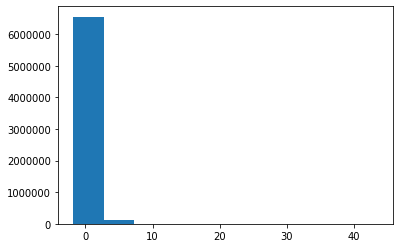

In [27]:
plt.hist(dataTrainSample1[:,10])

(array([6.647913e+06, 6.360000e+02, 2.383000e+03, 9.262000e+03,
        3.032000e+03, 1.550000e+02, 2.100000e+01, 6.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([3.48564088e-10, 1.02539733e+01, 2.05079465e+01, 3.07619198e+01,
        4.10158931e+01, 5.12698663e+01, 6.15238396e+01, 7.17778129e+01,
        8.20317861e+01, 9.22857594e+01, 1.02539733e+02]),
 <a list of 10 Patch objects>)

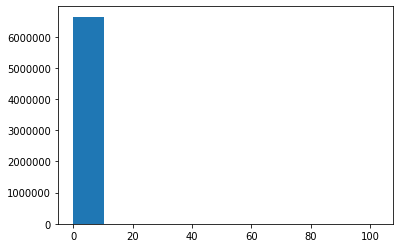

In [28]:
plt.hist(dataTrainWeight)

Create dataLoader for trainning and load to GPU. If no GPU avaliable, use "torch.device("cpu")
Batch size in trainning: 5000. Use large batch size due to signal and background event num is highly unbalanced.

In [29]:
num_cpu=multiprocessing.cpu_count()
print(num_cpu)

16


In [30]:
drv.init()
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float)#.to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float)#.to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float)#.to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float)#.to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=50000, shuffle=False,num_workers=num_cpu-10,pin_memory=True)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float)#.to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float)#.to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=30000, shuffle=False,num_workers=num_cpu-10,pin_memory=True)

Build model: 21 input variables, 3 hidden layer, 100 nodes per layer, 1 dropout=0.2

Mish: a new Non-Monotonic Neural Activation Function. Better performance and stablity than ReLU. Refernce: https://arxiv.org/pdf/1908.08681.pdf

In [31]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [32]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(22, 100),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu3 = Mish()
        self.fc4 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu4 = Mish()
        self.out = nn.utils.weight_norm(nn.Linear(100, 1),name='weight')
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [33]:
class ResNet(nn.Module):
    
    def __init__(self,dim):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(dim, 100),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu3 = Mish()
        self.out = nn.utils.weight_norm(nn.Linear(100, dim),name='weight')
        self.out_act = Mish()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        #dout = self.dout(h1)
        a2 = self.fc2(h1)
        h2 = self.relu2(a2)
        a3 = self.fc3(h2)
        h3 = self.relu3(a3)
        a4 = self.out(h3)
        y = self.out_act(a4+input_)
        return y

Init weights in each layer use xavier normal:

In [34]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

trainning part:

In [35]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/sample_weight.mean()
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

evaluation part:

In [36]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/sample_weight.mean()
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

Send model to GPU and inital weights

In [37]:
model = Net().to(device)
#model=nn.Sequential(nn.utils.weight_norm(nn.Linear(22, 100),name='weight'),Mish(),ResNet(100),ResNet(100),ResNet(100),ResNet(100),nn.utils.weight_norm(nn.Linear(100, 100),name='weight'),Mish(),nn.utils.weight_norm(nn.Linear(100, 1),name='weight'),nn.Sigmoid()).to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=22, out_features=100, bias=True)
  (relu1): Mish()
  (dout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): Mish()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): Mish()
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (relu4): Mish()
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

Loss: Binary Cross Entropy:

In [38]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Trainning model. Evaluate model after each epoches. Stop trainning if evaluate loss doesn't decrease for 4 epoches:

In [39]:
def train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, max_epoch, patient):
    lowest_loss=9999
    counter=0
    best_epoch=0
    pat=patient
    loss_np=np.zeros((max_epoch,1))
    loss_test_np=np.zeros((max_epoch,1))
    for epoch in range(1, max_epoch):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
    return(loss_np,loss_test_np,best_epoch)
        

In [40]:
loss_np, loss_test_np, best_epoch = train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, 300, 4)

Train Epoch: 1 [0/6663411 (0%)]	Loss: 0.693188
Train Epoch: 1 [500000/6663411 (7%)]	Loss: 0.650668
Train Epoch: 1 [1000000/6663411 (15%)]	Loss: 0.553353
Train Epoch: 1 [1500000/6663411 (22%)]	Loss: 0.472659
Train Epoch: 1 [2000000/6663411 (30%)]	Loss: 0.537519
Train Epoch: 1 [2500000/6663411 (37%)]	Loss: 0.441056
Train Epoch: 1 [3000000/6663411 (45%)]	Loss: 0.400773
Train Epoch: 1 [3500000/6663411 (52%)]	Loss: 0.408235
Train Epoch: 1 [4000000/6663411 (60%)]	Loss: 0.404792
Train Epoch: 1 [4500000/6663411 (67%)]	Loss: 0.390578
Train Epoch: 1 [5000000/6663411 (75%)]	Loss: 0.372088
Train Epoch: 1 [5500000/6663411 (82%)]	Loss: 0.332920
Train Epoch: 1 [6000000/6663411 (90%)]	Loss: 0.363931
Train Epoch: 1 [6500000/6663411 (97%)]	Loss: 0.376866
Average loss in epoch  1  is:  0.4529814542229496
Train Epoch: 2 [0/6663411 (0%)]	Loss: 0.402225
Train Epoch: 2 [500000/6663411 (7%)]	Loss: 0.379970
Train Epoch: 2 [1000000/6663411 (15%)]	Loss: 0.382067
Train Epoch: 2 [1500000/6663411 (22%)]	Loss: 0.330

Train Epoch: 11 [2000000/6663411 (30%)]	Loss: 0.360939
Train Epoch: 11 [2500000/6663411 (37%)]	Loss: 0.273587
Train Epoch: 11 [3000000/6663411 (45%)]	Loss: 0.268136
Train Epoch: 11 [3500000/6663411 (52%)]	Loss: 0.250282
Train Epoch: 11 [4000000/6663411 (60%)]	Loss: 0.283282
Train Epoch: 11 [4500000/6663411 (67%)]	Loss: 0.292429
Train Epoch: 11 [5000000/6663411 (75%)]	Loss: 0.240133
Train Epoch: 11 [5500000/6663411 (82%)]	Loss: 0.241520
Train Epoch: 11 [6000000/6663411 (90%)]	Loss: 0.263548
Train Epoch: 11 [6500000/6663411 (97%)]	Loss: 0.279066
Average loss in epoch  11  is:  0.2793205319278276
Train Epoch: 12 [0/6663411 (0%)]	Loss: 0.296549
Train Epoch: 12 [500000/6663411 (7%)]	Loss: 0.267900
Train Epoch: 12 [1000000/6663411 (15%)]	Loss: 0.285642
Train Epoch: 12 [1500000/6663411 (22%)]	Loss: 0.251366
Train Epoch: 12 [2000000/6663411 (30%)]	Loss: 0.350682
Train Epoch: 12 [2500000/6663411 (37%)]	Loss: 0.277134
Train Epoch: 12 [3000000/6663411 (45%)]	Loss: 0.282516
Train Epoch: 12 [350000

Train Epoch: 21 [3000000/6663411 (45%)]	Loss: 0.264600
Train Epoch: 21 [3500000/6663411 (52%)]	Loss: 0.227345
Train Epoch: 21 [4000000/6663411 (60%)]	Loss: 0.266892
Train Epoch: 21 [4500000/6663411 (67%)]	Loss: 0.271302
Train Epoch: 21 [5000000/6663411 (75%)]	Loss: 0.231268
Train Epoch: 21 [5500000/6663411 (82%)]	Loss: 0.232781
Train Epoch: 21 [6000000/6663411 (90%)]	Loss: 0.247541
Train Epoch: 21 [6500000/6663411 (97%)]	Loss: 0.273913
Average loss in epoch  21  is:  0.2711327005900554
Train Epoch: 22 [0/6663411 (0%)]	Loss: 0.290836
Train Epoch: 22 [500000/6663411 (7%)]	Loss: 0.261236
Train Epoch: 22 [1000000/6663411 (15%)]	Loss: 0.276279
Train Epoch: 22 [1500000/6663411 (22%)]	Loss: 0.248398
Train Epoch: 22 [2000000/6663411 (30%)]	Loss: 0.334740
Train Epoch: 22 [2500000/6663411 (37%)]	Loss: 0.266393
Train Epoch: 22 [3000000/6663411 (45%)]	Loss: 0.278754
Train Epoch: 22 [3500000/6663411 (52%)]	Loss: 0.232786
Train Epoch: 22 [4000000/6663411 (60%)]	Loss: 0.271634
Train Epoch: 22 [450000

Train Epoch: 31 [4000000/6663411 (60%)]	Loss: 0.253731
Train Epoch: 31 [4500000/6663411 (67%)]	Loss: 0.264189
Train Epoch: 31 [5000000/6663411 (75%)]	Loss: 0.232211
Train Epoch: 31 [5500000/6663411 (82%)]	Loss: 0.229745
Train Epoch: 31 [6000000/6663411 (90%)]	Loss: 0.258912
Train Epoch: 31 [6500000/6663411 (97%)]	Loss: 0.276079
Average loss in epoch  31  is:  0.26524398575967817
Train Epoch: 32 [0/6663411 (0%)]	Loss: 0.293830
Train Epoch: 32 [500000/6663411 (7%)]	Loss: 0.259713
Train Epoch: 32 [1000000/6663411 (15%)]	Loss: 0.266069
Train Epoch: 32 [1500000/6663411 (22%)]	Loss: 0.242051
Train Epoch: 32 [2000000/6663411 (30%)]	Loss: 0.348689
Train Epoch: 32 [2500000/6663411 (37%)]	Loss: 0.281292
Train Epoch: 32 [3000000/6663411 (45%)]	Loss: 0.283072
Train Epoch: 32 [3500000/6663411 (52%)]	Loss: 0.222909
Train Epoch: 32 [4000000/6663411 (60%)]	Loss: 0.258145
Train Epoch: 32 [4500000/6663411 (67%)]	Loss: 0.265432
Train Epoch: 32 [5000000/6663411 (75%)]	Loss: 0.233758
Train Epoch: 32 [55000

Train Epoch: 41 [5000000/6663411 (75%)]	Loss: 0.223122
Train Epoch: 41 [5500000/6663411 (82%)]	Loss: 0.222744
Train Epoch: 41 [6000000/6663411 (90%)]	Loss: 0.241656
Train Epoch: 41 [6500000/6663411 (97%)]	Loss: 0.286573
Average loss in epoch  41  is:  0.2603181389285557
Train Epoch: 42 [0/6663411 (0%)]	Loss: 0.278024
Train Epoch: 42 [500000/6663411 (7%)]	Loss: 0.241726
Train Epoch: 42 [1000000/6663411 (15%)]	Loss: 0.278945
Train Epoch: 42 [1500000/6663411 (22%)]	Loss: 0.240749
Train Epoch: 42 [2000000/6663411 (30%)]	Loss: 0.318236
Train Epoch: 42 [2500000/6663411 (37%)]	Loss: 0.267481
Train Epoch: 42 [3000000/6663411 (45%)]	Loss: 0.266980
Train Epoch: 42 [3500000/6663411 (52%)]	Loss: 0.226061
Train Epoch: 42 [4000000/6663411 (60%)]	Loss: 0.256338
Train Epoch: 42 [4500000/6663411 (67%)]	Loss: 0.254560
Train Epoch: 42 [5000000/6663411 (75%)]	Loss: 0.225458
Train Epoch: 42 [5500000/6663411 (82%)]	Loss: 0.218975
Train Epoch: 42 [6000000/6663411 (90%)]	Loss: 0.245059
Train Epoch: 42 [650000

Train Epoch: 51 [6000000/6663411 (90%)]	Loss: 0.231229
Train Epoch: 51 [6500000/6663411 (97%)]	Loss: 0.274923
Average loss in epoch  51  is:  0.2574721531414274
Train Epoch: 52 [0/6663411 (0%)]	Loss: 0.289160
Train Epoch: 52 [500000/6663411 (7%)]	Loss: 0.254130
Train Epoch: 52 [1000000/6663411 (15%)]	Loss: 0.264577
Train Epoch: 52 [1500000/6663411 (22%)]	Loss: 0.236034
Train Epoch: 52 [2000000/6663411 (30%)]	Loss: 0.315175
Train Epoch: 52 [2500000/6663411 (37%)]	Loss: 0.254431
Train Epoch: 52 [3000000/6663411 (45%)]	Loss: 0.269473
Train Epoch: 52 [3500000/6663411 (52%)]	Loss: 0.216191
Train Epoch: 52 [4000000/6663411 (60%)]	Loss: 0.257718
Train Epoch: 52 [4500000/6663411 (67%)]	Loss: 0.275210
Train Epoch: 52 [5000000/6663411 (75%)]	Loss: 0.219262
Train Epoch: 52 [5500000/6663411 (82%)]	Loss: 0.225508
Train Epoch: 52 [6000000/6663411 (90%)]	Loss: 0.234554
Train Epoch: 52 [6500000/6663411 (97%)]	Loss: 0.282838
Average loss in epoch  52  is:  0.2575719445499022
Train Epoch: 53 [0/6663411 

Create learning curve for both trainning and evaluation proceess:

In [ ]:
loss_train=loss_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.2,0.6)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/1122/loss-region4-no1000.gif', writer='imagemagick', fps=30)
plt.show()

In [ ]:
loss_train=loss_test_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.2,0.6)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/1122/loss-region4-test-no1000.gif', writer='imagemagick', fps=30)
plt.show()

Free GPU memory:

In [41]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

Apply DNN model function:

In [42]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

Test DNN model on signal and background dataset:

In [ ]:
signalTensor = torch.tensor(signalSample1, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
#plt.text(0.1, 2.5,'$\mathit{ATLAS}$', fontsize=15)
#plt.text(0.29, 2.5,'Internal', fontsize=12)
#plt.text(0.15,2.3,'$ 139 fb^{-1}$',fontsize=12)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1122/NN-region4-sig-no1000.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
bakTensor= torch.tensor(backgroundSample1, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

plt.hist(bakScore,bins=20,weights=backgroundWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1122/NN-region4-bkg-no1000.pdf', format='pdf', dpi=500)
plt.show()

Create trainning and testing ROC curve:

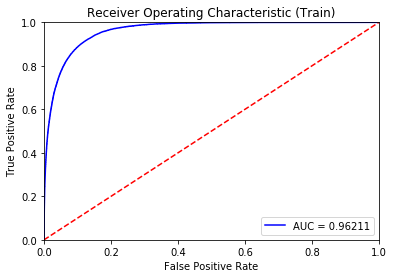

In [43]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=10000, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1122/roc-region4-train-DNN-400.pdf', format='pdf', dpi=500)
plt.show()

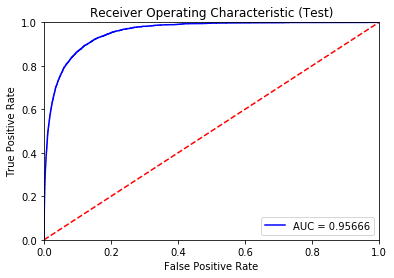

In [44]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=10000, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1122/roc-region4-test-DNN-400.pdf', format='pdf', dpi=500)
plt.show()

Save DNN model:

In [45]:
torch.save(model.state_dict(),'../pDNN_model/region4-pytorch-1122-400.pt')

Cuda funciton used to calculate yields with different DNN cut:

In [ ]:
reload(cuda_guass_normal)

Scan Limits and significance use different DNN cut:

In [ ]:
def cal_limit(bkg,sig):
    p=1.0
    num=int(bkg)+1
    mu=0
    while(p>0.05):
        p=poisson.cdf(num, bkg+mu*sig)
        mu=mu+0.01
    return(mu)

limit=np.zeros((20,1))
x=np.zeros((20,1))
sig=np.zeros((20,1))
k=0
for i in np.arange(0.8,1,0.01):
    resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,i)
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    x[k]=i
    limit[k]=cal_limit(resB,resS)
    sig[k]=resS/sqrt(resB)
    k=k+1

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,limit)
plt.xlabel("DNN Cut")
plt.ylabel("95% CL Upper Limit")
plt.title("Upper Limits in HM/SF Region")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/Limits-Region3.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,sig)
plt.xlabel("DNN Cut")
plt.ylabel("S/sqrt(B)")
plt.title("Significance in HM/SF Region")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/Sig-Region3.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.1):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

XGBoost part:

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample,feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample,feature_names=varName)
param = {'max_depth': 5, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
#if no GPU, use param['tree_methond']='hist'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval')]

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(GBDT,importance_type="gain",ax=ax)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1122/ranking-region4-gain-1000.pdf', format='pdf', dpi=500)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/roc-region4-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/roc-region4-test-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(BackgroundScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)